In [7]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt

# load the configuration file
from l5kit.configs import load_config_data
from l5kit.configs.config import load_metadata
# load the dataset from zarr
from l5kit.data import ChunkedDataset, LocalDataManager
# load the Ego/Agent-based dataset
from l5kit.dataset import EgoDataset, AgentDataset
# define the road_network protobuf data structure
from l5kit.data.proto.road_network_pb2 import RoadNetworkNode, RoadNetworkSegment
# Semantic map api
from l5kit.data.map_api import MapAPI
# rasterizer
from l5kit.rasterization import build_rasterizer
# geometry
from l5kit.geometry import transform_points

In [8]:
pwd

'C:\\Users\\LocalAdmin\\Documents\\GitHub\\lyft_intersection\\extract_intersections\\notebook'

In [3]:
# load the configuration file
cfg = load_config_data("../yaml_config/visualisation_config_sample.yaml")
print(cfg)

# load the dataset from zarr
os.environ["L5KIT_DATA_FOLDER"] = "../" ## Set the environmental variable
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
# print(dataset_path) # scenes\sample.zarr
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_num_frames_ego': 0, 'history_num_frames_agents': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_satellite', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.9, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes-sample/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scen

`Lat & Lon`: `(37.419, -122.150)` | `(37.419144, -122.150620)`

Find the frames which include this intersection of interset.

In [4]:
cfg["raster_params"]["map_type"] = "semantic_debug" # "py_satellite" 
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
for frame_index in range(24838):
    if frame_index % 1000 == 0:
        print(frame_index)
    data = dataset[frame_index]

0
1000
2000
3000
4000
5000
6000


KeyboardInterrupt: 

Display the frame using different kinds of rasterizers (`py_satellite`, `py_semantic`, `semantic_debug` ...).

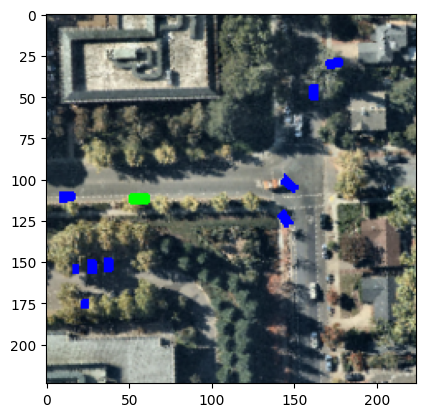

In [8]:
frameIndex = 1900

# visualize the scene
cfg["raster_params"]["map_type"] = "semantic_debug" # "py_satellite" # 
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[frameIndex]

im = data["image"].transpose(1, 2, 0) # (224, 224, 5)
im = dataset.rasterizer.to_rgb(im) # (224, 224, 3)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
# draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

# visualize the scene
cfg["raster_params"]["map_type"] = "py_satellite" # 
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[frameIndex]

im = data["image"].transpose(1, 2, 0) # (224, 224, 5)
im = dataset.rasterizer.to_rgb(im) # (224, 224, 3)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
# draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

Generate a GIF animation for a specific scene (240+ frames).

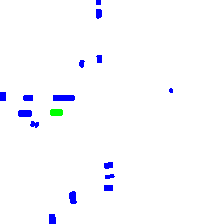

In [9]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 10
indexes = dataset.get_scene_indices(scene_idx)
for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    # draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
    clear_output(wait=True)
    display(PIL.Image.fromarray(im))

Test the modified `MapAPI` class which parses the Junction information.

In [9]:
from l5kit.data.proto.road_network_pb2 import GeoFrame, GlobalId, MapElement, MapFragment

dataset_meta_key = cfg["raster_params"]["dataset_meta_key"]
dataset_meta = load_metadata(dm.require(dataset_meta_key))
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
mapAPI = MapAPI(protobuf_map_path="../semantic_map/semantic_map.pb", world_to_ecef=world_to_ecef)

with open("../semantic_map/semantic_map.pb", "rb") as infile:
            mf = MapFragment()
            mf.ParseFromString(infile.read())

mapAPI.bounds_info.keys()

dict_keys(['lanes', 'crosswalks', 'junctions'])

Report the MapElements included in the semantic map file

In [10]:
# what elements do mf have?
elements = []
for index in range(mf.elements.__len__()):
    elements.append(str(mf.elements[index].element).split(" ")[0])
# set(elements

# report the frequency of each kind of element
from collections import Counter
counter = Counter(elements)
for element, count in counter.items():
    print(f"{element}: {count}")

traffic_control_element: 2155
lane: 8505
node: 1382
segment: 1767
junction: 917
annotated_shape: 527


In [44]:
for index in range(mf.elements.__len__()):
    map_element_string = str(mf.elements[index].element)
    if str(map_element_string).split(" ")[0] == "junction":
        if "VJK2" in map_element_string:
            print(mf.elements[index])
        
        

id {
  id: "sGK1"
}
element {
  junction {
    road_network_nodes {
      id: "VJK2"
    }
    traffic_control_elements {
      id: "/myU"
    }
    traffic_control_elements {
      id: "/+/X"
    }
    traffic_control_elements {
      id: "X7pg"
    }
    traffic_control_elements {
      id: "yy+g"
    }
    traffic_control_elements {
      id: "C4EV"
    }
    traffic_control_elements {
      id: "oLxb"
    }
    traffic_control_elements {
      id: "XyPQ"
    }
    lanes {
      id: "2n/z"
    }
    lanes {
      id: "F83z"
    }
    lanes {
      id: "hbtQ"
    }
    lanes {
      id: "N3wG"
    }
    lanes {
      id: "3w6K"
    }
    lanes {
      id: "qwzI"
    }
    lanes {
      id: "AcOB"
    }
    lanes {
      id: "F/RY"
    }
    is_non_trivial_intersection: true
  }
}
bounding_box {
  south_west {
    lat_e7: 374191958
    lng_e7: -1221507427
  }
  north_east {
    lat_e7: 374191958
    lng_e7: -1221507427
  }
}



Demonstrate the structure of the MapElement (i.e. Junction).

In [19]:
elements = []
for index in range(mf.elements.__len__()):
    if str(mf.elements[index].element).split(" ")[0] == "node":
        # print(str(mf.elements[index].element))
        elements.append((mf.elements[index].element))

node {
  location {
    lat_e7: 374275280
    lng_e7: -1221502459
    altitude_cm: -2056
  }
  road_segments {
    id: "+Bp8"
  }
  road_segments {
    id: "E7Tu"
  }
  road_segments {
    id: "hLY3"
  }
  junction {
  }
}

Find the nodes that are close to the point of interest.

In [42]:
# retrieve all the nodes 
node_elements = []
node_ids = []
node_elements_coords = []

for index in range(mf.elements.__len__()):
    if str(mf.elements[index].element).split(" ")[0] == "node":
        # print(str(mf.elements[index].element))
        node_elements.append(mf.elements[index].element)
        node_ids.append(mf.elements[index].id)
        lat = mf.elements[index].element.node.location.lat_e7
        lon = mf.elements[index].element.node.location.lng_e7
        node_elements_coords.append((lat, lon))

# target coordinate: 37.419144, -122.150620 
# try to find the nodes that are close to the target node.
target_lat = 374191440
target_lon = -1221506200
radius = 3000

for idx, (lat, lon) in enumerate(node_elements_coords):
    if lat < target_lat + radius and target_lat - radius < lat and target_lon - radius < lon and lon < target_lon + radius:
        # print(lat, lon)
        print(node_elements[idx])
        print(node_ids[idx])

node {
  location {
    lat_e7: 374191958
    lng_e7: -1221507427
    altitude_cm: -1745
  }
  road_segments {
    id: "bpHP"
  }
  road_segments {
    id: "Iyco"
  }
  road_segments {
    id: "UpA2"
  }
  junction {
  }
}

id: "VJK2"

node {
  location {
    lat_e7: 374192569
    lng_e7: -1221508600
    altitude_cm: -1729
  }
  road_segments {
    id: "94CO"
  }
  junction {
  }
}

id: "RMgS"



In [38]:
"sGK1" in mapAPI.bounds_info["junctions"]["ids"]

True

Explore how many lanes each junction has.